In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

In [2]:
os.getcwd()

'/gscmnt/gc2508/dinglab/estorrs/ancestry/notebooks'

In [102]:
THOUSAND_GENOMES_VCF = '/gscmnt/gc2508/dinglab/estorrs/ancestry/data/hg38/all.coding.sorted.02maf.snps.50000sampled.sorted.chr.vcf'
SAMPLES_VCF = '/gscmnt/gc2508/dinglab/estorrs/cptac3/ancestry_execution/ccrcc/genotype_calling/results/output.vcf'
THOUSAND_GENOMES_PANEL = '/gscmnt/gc2508/dinglab/estorrs/ancestry/data/integrated_call_samples_v3.20130502.ALL.panel'

OUTPUT_DIR = '/gscmnt/gc2508/dinglab/estorrs/cptac3/ancestry_execution/ccrcc/ancestry_prediction/'
STATS_FILE = os.path.join(OUTPUT_DIR, 'model.stats')
PREDICTIONS_FILE = os.path.join(OUTPUT_DIR, 'predictions.tsv')




In [103]:
stats_dict = {}

In [104]:
def get_vcf_df(vcf_fp, stop_on='#CHROM'):
    f = open(vcf_fp)

    line = ''
    header = ''
    while True:
        line = f.readline()
        if line[:6] == stop_on:
            break
            
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = line[1:].strip().replace('""', '').split('\t')
    df.index = df['ID']
    df.index.name = ''
    
    # remove X chromosome
    df = df[df['CHROM'] != 'X']
    
    # grab the columns we want
    df = df[df.columns[9:]]

    # transpose dataframe so samples are rows, mutations are columns
    df = df.transpose()
    
    # replace phased calls
#     df = df.replace(re.compile(r'^1\|0'), '0|1')

    sample_ids = list(df.index)
    
    f.close()
    
    return df, sample_ids

In [105]:
def get_ancestry_map(map_fp):
    f = open(map_fp)
    
    # dump header
    f.readline()
    
    ancestry_map = {}
    for line in f:
        sample_id, _, ancestry, _ = line.strip().split('\t')
        
        ancestry_map[sample_id] = ancestry
        
    
    return ancestry_map

In [106]:
# read in 1000 Genomes Project data
thousand_genomes_df, thousand_genomes_sample_ids = get_vcf_df(THOUSAND_GENOMES_VCF)

stats_dict['inputs_before_drop'] = {
    'thousand_genomes_num_samples': thousand_genomes_df.shape[0],
    'thousand_genomes_num_variants': thousand_genomes_df.shape[1]
}

print(thousand_genomes_df.shape)
thousand_genomes_df.head()

(2504, 49959)


,rs6560827,rs4431953,rs3740304,rs77703732,rs10904083,rs6560837,rs148318899,rs7918118,rs3207775,rs1044261,...,.,.,.,.,.,.,.,.,.,.
HG00096,1|1,1|1,1|0,0|0,1|0,1|1,0|0,1|0,0|0,0|0,...,0|0,0|0,0|0,1|0,1|0,0|1,0|2,0|1,1|0,0|0
HG00097,0|1,0|1,0|0,0|0,1|0,1|1,0|0,1|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|1,2|0,1|1,0|0,0|0
HG00099,1|1,1|1,0|0,0|0,0|1,1|1,0|0,1|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|1,0|1,1|1,0|0,0|0
HG00100,1|1,0|1,0|0,0|0,0|0,1|1,0|0,1|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|0,2|0,1|0,0|0,0|0
HG00101,1|1,1|0,0|0,0|0,0|1,1|1,0|0,1|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|0,0|2,1|1,0|0,0|0


In [107]:
# read in samples data
samples_df, sample_ids = get_vcf_df(SAMPLES_VCF)
samples_df.columns = thousand_genomes_df.columns

stats_dict['inputs_before_drop'].update({
    'input_num_samples': samples_df.shape[0],
    'input_num_variants': samples_df.shape[1]
})

print(samples_df.shape)
samples_df.head()

(94, 49959)


,rs6560827,rs4431953,rs3740304,rs77703732,rs10904083,rs6560837,rs148318899,rs7918118,rs3207775,rs1044261,...,.,.,.,.,.,.,.,.,.,.
C3L-00004,0|1,0|1,0|0,0|0,0|0,1|1,0|1,.|.,0|0,0|0,...,0|0,0|0,0|0,0|1,0|0,1|1,.|.,1|1,0|0,0|0
C3L-00010,0|0,0|1,0|0,0|0,0|1,1|1,.|.,.|.,0|0,0|0,...,0|0,0|1,0|0,0|0,0|0,0|0,.|.,0|1,0|0,0|0
C3L-00011,0|1,0|1,0|1,0|0,0|0,1|1,.|.,.|.,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|1,.|.,1|1,0|0,0|0
C3L-00026,1|1,0|1,0|1,0|0,0|0,1|1,0|0,.|.,0|1,0|0,...,0|0,0|0,0|1,0|0,0|0,0|1,.|.,0|1,0|0,0|0
C3L-00079,0|0,0|1,0|0,0|0,0|0,1|1,.|.,.|.,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,1|1,.|.,1|1,0|0,0|0


In [108]:
# shorten for testing
thousand_genomes_df = thousand_genomes_df.iloc[:, :2000]
samples_df = samples_df.iloc[:, :2000]

In [109]:
samples_df.head()

,rs6560827,rs4431953,rs3740304,rs77703732,rs10904083,rs6560837,rs148318899,rs7918118,rs3207775,rs1044261,...,rs59495679,rs10829325,rs10829326,rs12572632,rs12569557,rs11016050,rs2275803,rs7085589,rs3210509,rs7474666
C3L-00004,0|1,0|1,0|0,0|0,0|0,1|1,0|1,.|.,0|0,0|0,...,0|0,0|1,.|.,0|0,.|.,0|0,0|0,.|.,.|.,.|.
C3L-00010,0|0,0|1,0|0,0|0,0|1,1|1,.|.,.|.,0|0,0|0,...,0|0,0|1,.|.,.|.,.|.,0|1,0|1,.|.,.|.,.|.
C3L-00011,0|1,0|1,0|1,0|0,0|0,1|1,.|.,.|.,0|0,0|0,...,0|0,0|0,0|1,.|.,.|.,.|.,0|1,.|.,.|.,.|.
C3L-00026,1|1,0|1,0|1,0|0,0|0,1|1,0|0,.|.,0|1,0|0,...,0|0,0|0,.|.,.|.,.|.,.|.,0|1,.|.,.|.,.|.
C3L-00079,0|0,0|1,0|0,0|0,0|0,1|1,.|.,.|.,0|0,0|0,...,0|0,0|1,1|1,0|0,.|.,0|0,0|0,.|.,.|.,.|.


In [110]:
## filter variants for missingness
to_drop = []
for i, c in enumerate(samples_df.columns):
    if i % 1000 == 0:
        print(i)
#         raise RuntimeError()
#     missing_count = np.count_nonzero(~np.isnan(samples_df[c]))
    missing_count = len([x for x in samples_df[c]
                    if x == '.|.'])
#     print(missing_count)
    if missing_count / samples_df.shape[0] > .05:
        to_drop.append(c)
print(len(to_drop))
print(len(to_drop) / samples_df.shape[1])

stats_dict['percent_of_variants_dropped'] = len(to_drop) / samples_df.shape[1]
stats_dict['num_variants_dropped'] = len(to_drop)

0
1000
609
0.3045


In [111]:
thousand_genomes_df = thousand_genomes_df.drop(to_drop, axis=1)
samples_df = samples_df.drop(to_drop, axis=1)
thousand_genomes_df.shape, samples_df.shape

stats_dict['inputs_after_drop'] = {
    'thousand_genomes_num_samples': thousand_genomes_df.shape[0],
    'thousand_genomes_num_variants': thousand_genomes_df.shape[1],
    'input_num_samples': samples_df.shape[0],
    'input_num_variants': samples_df.shape[1]
}

In [112]:
# df = df.replace(re.compile(r'^1\|0'), '0|1')
# df.head()

In [113]:
kk

,ancestry
HG00096,EUR
HG00097,EUR
HG00099,EUR
HG00100,EUR
HG00101,EUR


In [114]:
# shuffle and split into training and test sets
test_size = .2
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    thousand_genomes_df, target_df, test_size=test_size, random_state=123)

In [115]:
X_train_df.shape, X_test_df.shape
stats_dict['model'] = {
    'test_split': test_size
}

In [116]:
X_train, X_test = X_train_df.values, X_test_df.values
y_train, y_test = (np.reshape(y_train_df.values, (y_train_df.shape[0],)),
                   np.reshape(y_test_df.values, (y_test_df.shape[0],)))

In [117]:

# encode our categorical variables as vectors
genotype_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
genotype_encoder.fit(X_train)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False)

In [119]:
X_train.shape

(2003, 5545)

In [120]:
pca = PCA(n_components=20)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [121]:
X_train_principle_components = pca.transform(X_train)

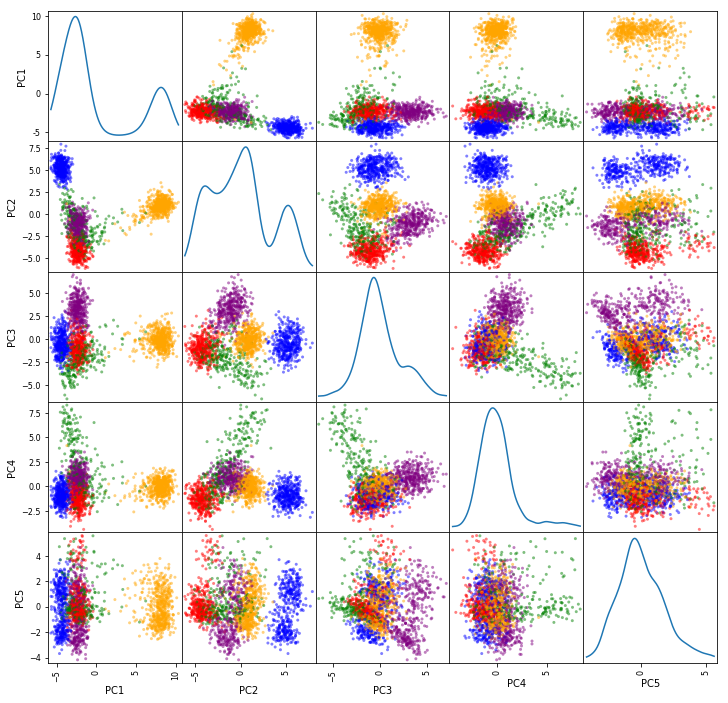

In [122]:
plotting_df = pd.DataFrame(data=X_train_principle_components[:, :5],
                          columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# axs = pd.plotting.scatter_matrix(plotting_df, figsize=(12,12), diagonal='kde')


ancestry_to_color = {'EUR': 'red',
                     'EAS': 'blue',
                     'AMR': 'green',
                     'AFR': 'orange',
                     'SAS': 'purple'}

colors = [ancestry_to_color[sample_id_to_ancestry[s_id]]
          for s_id in X_train_df.index]

axs = pd.plotting.scatter_matrix(plotting_df, color=colors,
                           figsize=(12,12), diagonal='kde')

lims = []
for subaxis in axs:
    ls = []
    for ax in subaxis:
        ls.append((ax.get_xlim(), ax.get_ylim()))
#         ax.xaxis.set_ticks([])
#         ax.yaxis.set_ticks([])
    lims.append(ls)
plt.savefig(os.path.join(OUTPUT_DIR, 'pc.training.pdf'), dpi=300, figsize=(12,12))
plt.savefig(os.path.join(OUTPUT_DIR, 'pc.training.png'), dpi=300, figsize=(12,12))

In [123]:
scaler = StandardScaler()
scaler.fit(X_train_principle_components)

X_train_principle_components = scaler.transform(X_train_principle_components)

X_train_principle_components.shape

(2003, 20)

In [124]:
# train our new model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_principle_components, y_train)

score = clf.score(X_train_principle_components, y_train)

stats_dict['model']['training_score'] = score

In [125]:
# test our new model
X_test = genotype_encoder.transform(X_test)

X_test_principle_components = pca.transform(X_test)

X_test_principle_components = scaler.transform(X_test_principle_components)

score = clf.score(X_test_principle_components, y_test)

stats_dict['model']['test_score'] = score

In [135]:
samples_test = samples_df.values

samples_test = genotype_encoder.transform(samples_test)

X_test_principle_components = pca.transform(samples_test)

X_test_principle_components = scaler.transform(X_test_principle_components)

predictions = clf.predict(X_test_principle_components)
probs = clf.predict_proba(X_test_principle_components)

In [137]:
sample_to_prediction = zip(sample_ids, predictions, probs)

out_f = open(PREDICTIONS_FILE, 'w')
out_f.write('sample_id\tpredicted_ancestry\tprobability_AFR\tprobability_AMR\tprobability_EAS\tprobability_EUR\tprobability_SAS\n')
for sample, prediction, prob in sample_to_prediction:
#     print(prob)
    out_f.write(f'{sample}\t{prediction}\t' + '\t'.join([str(x) for x in prob]) + '\n')
out_f.close()

In [138]:
stats_dict

{'inputs_before_drop': {'thousand_genomes_num_samples': 2504,
  'thousand_genomes_num_variants': 49959,
  'input_num_samples': 94,
  'input_num_variants': 49959},
 'percent_of_variants_dropped': 0.3045,
 'num_variants_dropped': 609,
 'inputs_after_drop': {'thousand_genomes_num_samples': 2504,
  'thousand_genomes_num_variants': 1391,
  'input_num_samples': 94,
  'input_num_variants': 1391},
 'model': {'test_split': 0.2,
  'training_score': 1.0,
  'test_score': 0.9520958083832335}}

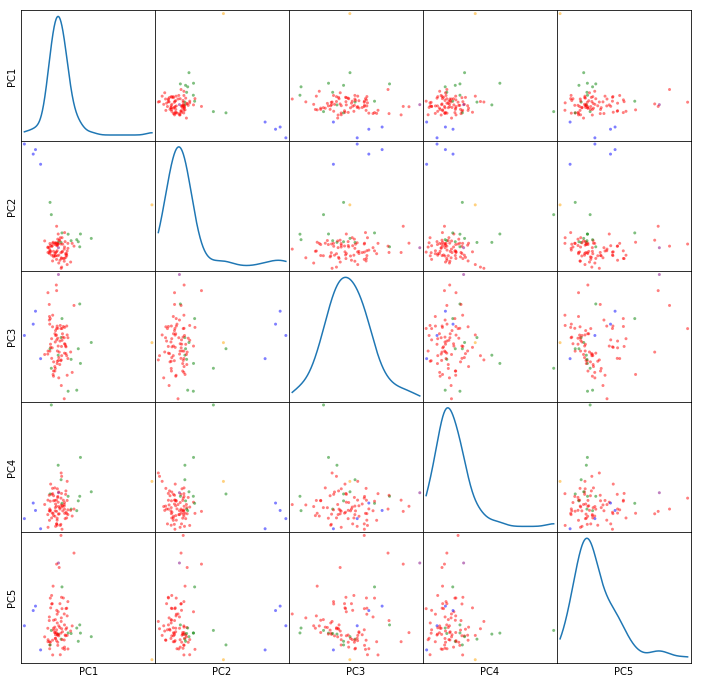

In [128]:
plotting_df = pd.DataFrame(data=X_test_principle_components[:, :5],
                          columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# axs = pd.plotting.scatter_matrix(plotting_df, figsize=(12,12), diagonal='kde')


ancestry_to_color = {'EUR': 'red',
                     'EAS': 'blue',
                     'AMR': 'green',
                     'AFR': 'orange',
                     'SAS': 'purple'}

colors = [ancestry_to_color[x]
          for x in predictions]

axs = pd.plotting.scatter_matrix(plotting_df, color=colors,
                           figsize=(12,12), diagonal='kde')

for i, subaxis in enumerate(axs):
    for j, ax in enumerate(subaxis):
#         ax.set_xlim(lims[i][j][0])
#         ax.set_ylim(lims[i][j][1])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.savefig(os.path.join(OUTPUT_DIR, 'pc.samples.pdf'), dpi=300, figsize=(12,12))
plt.savefig(os.path.join(OUTPUT_DIR, 'pc.samples.png'), dpi=300, figsize=(12,12))

In [ ]:
def get_headerless_vcf_df(f_obj, stop_on='#CHROM'):
    line = ''
    header = ''
    while True:
        line = f_obj.readline()
        header += line
        if line[:6] == stop_on:
            break
            
#     print(line)
            
    df = pd.read_csv(f_obj, sep='\t', header=None)
    df.columns = line[1:].replace('""', '').replace('\n', '').split('\t')

    return df, header

In [ ]:
def get_calls_matrix(vcf_fp):
    f_obj = open(vcf_fp)
    
    line = ''
    while True:
        line = f_obj.readline()
        if line[:6] == '#CHROM':
            break
    
    line = line.replace('\n', '')
    samples = line.split('\t')[SAMPLE_INDEX:]
    
    X = []
    for line in f_obj:
        line = line.replace('\n', '')
        pieces = line.split('\t')
        X.append(pieces[SAMPLE_INDEX:])
    
    return np.asarray(X), samples

In [ ]:
# CALLED_VCF_FP = '/diskmnt/Projects/Users/estorrs/data/ancestry/MM/temp/called_samples.vcf'
# GENOMES_VCF_FP = '/diskmnt/Projects/Users/estorrs/1000-genomes/GRCh37/all.coding.sorted.02maf.10000sampled.sorted.snps.vcf'

In [ ]:
CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/vcf/called.vcf'
# MM_CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MM/vcf/called.vcf'
MM_CALLED_VCF_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MM/readcounts_2/grch37.combined.vcf'
GENOMES_VCF_FP = '/gscmnt/gc2737/ding/estorrs/1000-genomes/GRCh37/all.coding.sorted.02maf.10000sampled.sorted.snps.vcf'
PREDICTIONS_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/predictions.tsv'
SELF_REPORTED_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/mmrf_self_reported.tsv'
MM_PAPER_SAMPLES_FP = '/gscmnt/gc2737/ding/estorrs/ancestry/MMRF/predictions/MM_paper_patients.tsv'

In [ ]:
# def preprocess_vcf(vcf_fp):
#     """Pull out X, convert to 
#     Returns:
#         (X, scaler)
#     """
#     calls_matrix, samples = get_calls_matrix(vcf_fp)
    
#     for i, row in enumerate(calls_matrix):
#         row = [re.sub(re.compile(r'^0\|[1-9]+|^[1-9]+\|0'), r'0|1', v) for v in row]
#         calls_matrix[i] = [re.sub(re.compile(r'^[1-9]+\|[1-9]+'), r'1|1', v) for v in row]
        
#     # encode calls
#     label_encoder = LabelEncoder()
#     label_encoder.fit(['.|.', '0|0', '0|1', '1|1', '0', '1'])
    
#     for i, row in enumerate(calls_matrix):
#         calls_matrix[i] = label_encoder.transform(row)
    
# #     print(ca)
    
#     calls_matrix = np.transpose(calls_matrix)
    
#     return calls_matrix, samples

def get_preprocessed_X(df):    
#     if drop_indices is None:
        
    
    # remove x
    df = df[df['CHROM'] != 'X']
    df = df[df['CHROM'] != 'chrX']
    
    trimmed_df = df[df.columns[9:]]
    samples = trimmed_df.columns
    
    trimmed_df = trimmed_df.replace(re.compile(r'^0\|[1-9]+|^[1-9]+\|0'), '0|1')
    trimmed_df = trimmed_df.replace(re.compile(r'^[1-9]+\|[1-9]+'), '1|1')
    
#     return trimmed_df
    # for X chrom
#     trimmed_df = trimmed_df.replace(re.compile(r'^[1-9]+$'), '1')
    
    # encode genotype
    label_encoder = LabelEncoder()
#     label_encoder.fit(['.|.', '0|0', '0|1', '1|1', '0', '1'])
    label_encoder.fit(['.|.', '0|0', '0|1', '1|1'])

    # encode the rows
    for i, row in trimmed_df.iterrows():
        trimmed_df.loc[i][:] = label_encoder.transform(row.values)
        
    X = trimmed_df.values

    # transpose so each row is now a sample
    X = X.transpose()
    
    return X, label_encoder, samples, trimmed_df
    

In [ ]:
df_genomes, _ = get_headerless_vcf_df(open(GENOMES_VCF_FP))
df_called, _ = get_headerless_vcf_df(open(CALLED_VCF_FP))
df_called_MM, _ = get_headerless_vcf_df(open(MM_CALLED_VCF_FP))

In [ ]:
df_genomes.shape, df_called.shape, df_called_MM.shape

In [ ]:
df_genomes.head(5)

In [ ]:
df_called_MM.head(5)

In [ ]:
df_called.head(5)

In [ ]:
df_genomes.tail(5)

In [ ]:
df_called_MM.tail(5)

In [ ]:
# drop rows with all missing
to_drop = []
for i, row in df_called.iterrows():
    if len([x for x in list(row[9:]) if x != '.|.']) <= len(row[9:]) * .95:
        to_drop.append(i)
        
for i, row in df_called_MM.iterrows():
    if len([x for x in list(row[9:]) if x != '.|.']) <= len(row[9:]) * .95:
        to_drop.append(i)

df_genomes = df_genomes.drop(to_drop) 
df_called = df_called.drop(to_drop)
df_called_MM = df_called_MM.drop(to_drop)

In [ ]:
df_genomes.shape, df_called.shape, df_called_MM.shape

In [ ]:
X_genomes_, encoder_genomes, samples_genomes, trimmed_df_genomes = get_preprocessed_X(df_genomes)

In [ ]:
X_called_, encoder_called, samples_called, trimmed_df_called = get_preprocessed_X(df_called)

In [ ]:
X_called_MM_, encoder_called_MM, samples_called_MM, trimmed_df_called_MM = get_preprocessed_X(df_called_MM)

In [ ]:
# make copys so you dont have to rerun a bunch of times
X_genomes = np.copy(X_genomes_)
X_called = np.copy(X_called_)
X_called_MM = np.copy(X_called_MM_)

In [ ]:
# impute missing values
imp_most_freq = SimpleImputer(missing_values=0, strategy='most_frequent')
X_genomes = imp_most_freq.fit_transform(X_genomes)
X_called = imp_most_freq.fit_transform(X_called)
X_called_MM = imp_most_freq.fit_transform(X_called_MM)

In [ ]:
X_genomes.shape, X_called.shape, X_called_MM.shape

In [ ]:
np.all(df_genomes['POS'] == df_called['POS'])

In [ ]:
pca_scaler = StandardScaler()
pca_scaler.fit(X_genomes)
X_genomes = pca_scaler.transform(X_genomes)

In [ ]:
X_called = pca_scaler.transform(X_called)

In [ ]:
X_called_MM = pca_scaler.transform(X_called_MM)

In [ ]:
# print(X_genomes.shape, X_called.shape)
# X = np.vstack((X_genomes, X_called))
# print(X.shape)

## PCA

In [ ]:
# pca_scaler = StandardScaler()
# pca_scaler.fit(X)
# X = pca_scaler.transform(X)

In [ ]:
# pca = PCA(n_components=20)
# pca.fit(X)
# pcs = pca.transform(X)

In [ ]:
# pcs_df = pd.DataFrame(pcs)
# pd.scatter_matrix(pcs_df.loc[:, :3], figsize=(12,12))

In [ ]:
pca = PCA(n_components=20)
pca.fit(X_genomes)
pcs_genomes = pca.transform(X_genomes)

In [ ]:
pcs_genomes_df = pd.DataFrame(pcs_genomes)
pd.scatter_matrix(pcs_genomes_df.loc[:, :3], figsize=(12,12))

In [ ]:
pcs_called = pca.transform(X_called)

In [ ]:
pcs_called_df = pd.DataFrame(pcs_called)
pd.scatter_matrix(pcs_called_df.loc[:, :3], figsize=(12,12))

In [ ]:
pcs_called_MM = pca.transform(X_called_MM)

In [ ]:
pcs_called_MM_df = pd.DataFrame(pcs_called_MM)
pd.scatter_matrix(pcs_called_MM_df.loc[:, :3], figsize=(12,12))

In [ ]:
# component_df = pd.DataFrame(pca.components_,columns=trimmed_df_genomes.index)

In [ ]:
# def get_most_informative_variants(df, variant_)

In [ ]:
# idxs = np.argsort(np.asarray([abs(x) for x in pca.components_[0, :]]))
# [idxs[-10:]]

## annotate 1000 genomes

In [ ]:
# load in 1000 genome labels
labels_df = pd.read_csv('/gscmnt/gc2737/ding/estorrs/1000-genomes/GRCh37/integrated_call_samples_v3.20130502.ALL.panel',
                       sep='\t')
labels_df.head()

In [ ]:
# make sure order still matches
np.all(df_genomes.columns[9:] == labels_df['sample'])

In [ ]:
sample_to_ancestry = {k:v for k, v in zip(labels_df['sample'], labels_df['super_pop'])}

ancestry_to_color = {'EUR': 'red', 'EAS': 'blue', 'AMR': 'green', 'AFR': 'orange', 'SAS': 'purple'}
colors = [ancestry_to_color[sample_to_ancestry[s]] for s in labels_df['sample']]

In [ ]:
# ## extract back out into called and 1000 genomes
# pcs_genomes_df = pcs_df[:X_genomes.shape[0]][:]
# pcs_called_df = pcs_df[X_genomes.shape[0]:][:]
# pcs_genomes_df.shape, pcs_called_df.shape

In [ ]:
def get_axis_limits(pcs_df, d=4):
    lims = []
    for i in range(d):
        c = pcs_df[i]
        lims.append((min(c), max(c)))
        
    return lims
        

In [ ]:
pd.scatter_matrix(pcs_genomes_df.loc[:, :3], color=colors, figsize=(12,12))

In [ ]:
lims = get_axis_limits(pcs_genomes_df)
lims

In [ ]:
ax = pd.plotting.scatter_matrix(pcs_called_df.loc[:, :3], figsize=(12,12), diagonal='kde')
# for i, (ax_min, ax_max) in enumerate(lims):
#     for j in range(len(lims)):
#         ax[i, j].set_ylim(ax_min, ax_max)
#         ax[j, i].set_xlim(ax_min, ax_max)

## do classifier

In [ ]:
# get target values
ancestries = labels_df['super_pop'].values
ancestry_encoder = LabelEncoder()
ancestry_encoder.fit(list(set(ancestries)))
y = ancestry_encoder.transform(ancestries)

In [ ]:
# do normalization
X = np.copy(pcs_genomes_df.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
rf_scaler = StandardScaler()
rf_scaler.fit(X_train)
X_train = rf_scaler.transform(X_train)
X_test = rf_scaler.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

In [ ]:
# train accuracy and test accuracy
clf.score(X_train, y_train), clf.score(X_test, y_test)

## classify samples

In [ ]:
# do classification of mm samples
samples = df_called.columns[9:]
X_samples = np.copy(pcs_called_df.values)
X_samples = rf_scaler.transform(X_samples)

predictions = clf.predict(X_samples)
predictions = ancestry_encoder.inverse_transform(predictions)

sample_to_predictions = {k:v for k, v in zip(samples, predictions)}
colors = [ancestry_to_color[sample_to_predictions[s]] for s in samples]

In [ ]:
ax = pd.plotting.scatter_matrix(pcs_called_df.loc[:, :3], color=colors, figsize=(12,12), diagonal='kde')
# for i, (ax_min, ax_max) in enumerate(lims):
#     for j in range(len(lims)):
#         ax[i, j].set_ylim(ax_min, ax_max)
#         ax[j, i].set_xlim(ax_min, ax_max)

In [ ]:
# do classification of mm 14 samples
samples_MM = df_called_MM.columns[9:]
X_samples_MM = np.copy(pcs_called_MM_df.values)
X_samples_MM = rf_scaler.transform(X_samples_MM)

predictions_MM = clf.predict(X_samples_MM)
predictions_MM = ancestry_encoder.inverse_transform(predictions_MM)

sample_to_predictions_MM = {k:v for k, v in zip(samples_MM, predictions_MM)}
colors = [ancestry_to_color[sample_to_predictions_MM[s]] for s in samples_MM]

In [ ]:
ax = pd.plotting.scatter_matrix(pcs_called_MM_df.loc[:, :3], color=colors, figsize=(12,12), diagonal='kde')
for i, (ax_min, ax_max) in enumerate(lims):
    for j in range(len(lims)):
        ax[i, j].set_ylim(ax_min, ax_max)
        ax[j, i].set_xlim(ax_min, ax_max)

In [ ]:
sample_prediction_tups = [(s, p) for s, p in sample_to_predictions.items()]
sample_prediction_tups = sorted(sample_prediction_tups, key=lambda x: x[0])
samps, preds = zip(*sample_prediction_tups)
prediction_df = pd.DataFrame.from_dict({
    'sample': samps,
    'predicted_ancestry': preds
})
prediction_df.head()

In [ ]:
prediction_df.to_csv(PREDICTIONS_FP, sep='\t', index=False)

## nice plot

In [ ]:
## deduplicate samples
def deduplicate_col(df, col_name):
    to_drop = []
    prev = None
    for i, row in df.iterrows():
        if prev is not None and prev == row[col_name]:
            to_drop.append(i)

        prev = row[col_name]
    
    return df.drop(to_drop) 

def pad_ax_limits(limits, padding=.05):
    return [(a - abs(padding * (b - a)), b + abs(padding * (b - a))) for a, b in limits]

In [ ]:
def scatterplot(df, x_dim, y_dim, category, colormap, shapemap=None, figsize=(10, 5), size=5, alpha=.7, fontsize=10,
               legend_props={}, save=None, title='', xlim=None, ylim=None):
    
 
    fig, ax = plt.subplots(figsize=figsize)
    
    for cat in sorted(list(set(df[category]))):
        mini_df = df[df[category]==cat]
        x = mini_df[x_dim]
        y = mini_df[y_dim]
        
        plt.scatter(x, y, c=colormap[cat], label=cat, s=size, alpha=alpha)            

    ax.set_title(title).set_fontsize(fontsize)
    ax.set_xlabel(x_dim).set_fontsize(fontsize)
    ax.set_ylabel(y_dim).set_fontsize(fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend(prop=legend_props)
    
    if save is None:
        plt.show()
    else:
        plt.savefig(save, dpi=1200)
        
def scatterplot_mult_shapes(df, x_dim, y_dim, category, kwargs_col, colormap, shapemap=None, figsize=(10, 5), size=5, alpha=.7, fontsize=10,
               legend_props={}, save=None, title='', xlim=None, ylim=None):
    
 
    fig, ax = plt.subplots(figsize=figsize)
    
    for cat in sorted(list(set(df[category]))):
        for kwarg_value in sorted(list(set(df[kwargs_col]))):
            mini_df = df[df[category]==cat]
            mini_df = mini_df[mini_df[kwargs_col] == kwarg_value]
            x = mini_df[x_dim]
            y = mini_df[y_dim]
            
            kws = kwarg_value.split('|')
            d = {x.split(':')[0]:x.split(':')[1] for x in kws}

            for k,v in d.items():
                if '.' in v:
                    try:
                        d[k] = float(v)
                    except ValueError:
                        pass
                elif v.isdigit():
                    d[k] = int(v)
            print(d)

            plt.scatter(x, y, c=colormap[cat], label=cat, **d)            

    ax.set_title(title).set_fontsize(fontsize)
    ax.set_xlabel(x_dim).set_fontsize(fontsize)
    ax.set_ylabel(y_dim).set_fontsize(fontsize)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend(prop=legend_props)
    
    if save is None:
        plt.show()
    else:
        plt.savefig(save, dpi=1200)

In [ ]:
padded_lims = pad_ax_limits(lims, padding=.1)
padded_lims

In [ ]:
genome_plot_df = pcs_genomes_df[[0, 1]]
genome_plot_df.columns = ['PC1', 'PC2']
genome_plot_df['Ancestry'] = list(labels_df['super_pop'])
scatterplot(genome_plot_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='1000 Genomes', xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
self_reported_df = pd.read_csv(SELF_REPORTED_FP, sep='\t')
self_reported_df.head()

In [ ]:
self_reported_df.columns = ['sample', 'self_reported_ancestry']
self_reported_df = self_reported_df.replace(1, 'EUR')
self_reported_df = self_reported_df.replace(2, 'AFR')
self_reported_df = self_reported_df.replace(3, 'OTHER')
self_reported_df.head()

In [ ]:
called_plot_df = pcs_called_df[[0, 1]]
called_plot_df.columns = ['PC1', 'PC2']
called_plot_df['Ancestry'] = list(predictions)

samples_called_shortened = [s[:-2] for s in samples_called]
called_plot_df['sample'] = samples_called_shortened
called_plot_df['sample_id'] = samples_called

called_plot_df = called_plot_df.merge(self_reported_df, on='sample')

deduplicated_called_plot_df = deduplicate_col(called_plot_df, 'sample')

In [ ]:
called_plot_df.shape, deduplicated_called_plot_df.shape

In [ ]:

scatterplot(deduplicated_called_plot_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='MMRF - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
Counter(deduplicated_called_plot_df['Ancestry'])

In [ ]:
self_reported_ancestry_to_color = {
    'EUR': ancestry_to_color['EUR'],
    'AFR': ancestry_to_color['AFR'],
    'OTHER': 'gray'
}


scatterplot(deduplicated_called_plot_df, 'PC1', 'PC2', 'self_reported_ancestry', self_reported_ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF - self reported', xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
Counter(deduplicated_called_plot_df['self_reported_ancestry'])

In [ ]:
MM_paper_samples = pd.read_csv(MM_PAPER_SAMPLES_FP, sep='\t', header=None)
MM_paper_samples = list(MM_paper_samples[0])
# MM_paper_samples

In [ ]:
MMRF_paper_df = deduplicated_called_plot_df[called_plot_df['sample'].isin(MM_paper_samples)]
MMRF_paper_df.shape

In [ ]:
scatterplot(MMRF_paper_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF paper - predicted', xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
Counter(MMRF_paper_df['Ancestry'])

In [ ]:
scatterplot(MMRF_paper_df, 'PC1', 'PC2', 'self_reported_ancestry', ancestry_to_color, size=8, figsize=(10, 10),
            fontsize=20, legend_props={'size': 15}, title='MMRF paper - self reported', xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
called_plot_MM_df = pcs_called_MM_df[[0, 1]]
called_plot_MM_df.columns = ['PC1', 'PC2']
called_plot_MM_df['Ancestry'] = list(predictions_MM)

In [ ]:

# scatterplot(called_plot_MM_df, 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
#            legend_props={'size': 15}, title='MM - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
samples_called_MM_shortened = [s.split('.')[0] for s in samples_called_MM]
called_plot_MM_df['sample'] = samples_called_MM_shortened
called_plot_MM_df['sample_id'] = samples_called_MM

In [ ]:
scatterplot(deduplicate_col(called_plot_MM_df, 'sample'), 'PC1', 'PC2', 'Ancestry', ancestry_to_color, size=8, figsize=(10, 10), fontsize=20,
           legend_props={'size': 15}, title='MM 14 samples - predicted', alpha=.7, xlim=padded_lims[0], ylim=padded_lims[1])

In [ ]:
called_plot_MM_df.head()

In [ ]:
df_1 = deduplicate_col(called_plot_MM_df, 'sample')
df_2 = MMRF_paper_df
df_3 = deduplicated_called_plot_df

pc1 = list(df_1['PC1']) + list(df_2['PC1']) + list(df_3['PC1'])
pc2 = list(df_1['PC2']) + list(df_2['PC2']) + list(df_3['PC2'])

ancestry = list(df_1['Ancestry']) + list(df_2['Ancestry']) + list(df_3['Ancestry'])
kwarg_strs = (['marker:v|s:150|alpha:.7'] * df_1.shape[0]) + (['marker:+|s:100|alpha:.7'] * df_2.shape[0]) + (['marker:.|s:20|alpha:.3'] * df_3.shape[0])
plt_df = pd.DataFrame.from_dict({
    'PC1': pc1,
    'PC2': pc2,
    'Ancestry': ancestry,
    'kwargs': kwarg_strs
})

In [ ]:
df_1.shape, df_2.shape, df_3.shape

In [ ]:
scatterplot_mult_shapes(plt_df, 'PC1', 'PC2', 'Ancestry', 'kwargs', ancestry_to_color, size=50, figsize=(10, 10),
                        fontsize=20, legend_props={'size': 10}, title='MM - predicted', alpha=.7,
                        xlim=padded_lims[0], ylim=padded_lims[1],
                        save='/gscmnt/gc2737/ding/estorrs/ancestry/figures/combined.pdf')

In [ ]:
lims

In [ ]:
!pwd

In [ ]:
scatterplot_mult_shapes(plt_df, 'PC1', 'PC2', 'Ancestry', 'kwargs', ancestry_to_color, size=50, figsize=(4, 4),
                        fontsize=20, legend_props={'size': 1}, title='MM - predicted', alpha=.7, xlim=[-18, -5],
                        ylim=[-22, -14], save='/gscmnt/gc2737/ding/estorrs/ancestry/figures/zoomed_eur.pdf')

# plt.savefig('zoomed_eur.pdf', dpi=1000)